# Introduction to Machine Learning
Welcome to part 5 of the Python for Fantasy Football series! This article will be the first of several posts on machine learning, where I will use expected goals as an example to show you how to create your own machine learning models in Python from start to finish.

If the thought of another article on expected goals bores you already, I encourage you to read on, as I won't be following the same approach as previous work for reasons that will become clearer later. Unfortunately this first post is quite lengthy due to the need to explain some basic concepts, but please don't be put off by the wordy introduction; creating your own machine learning models is easy once you get the hang of it!

In case you haven't read the previous articles in the 'Python for Fantasy Football' series, please go back and work through those first before continuing: __[Part 1](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__, __[Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-matchup-adjustment/)__, __[Part 3](http://www.fantasyfutopia.com/python-for-fantasy-football-getting-and-cleaning-data/)__, __[Part 4](http://www.fantasyfutopia.com/python-for-fantasy-football-apis-and-json-data/)__. As always, you can follow along with this post by downloading the notebook from my GitHub account.

## What is machine learning?
Imagine you wanted to calculate the net force on an object based on its mass and acceleration. Anyone who has studied basic physics should know that you simply need to multiply the mass and acceleration together, thanks to Isaac Newton's 2nd law of motion. This is a task that you could easily carry out yourself with a basic calculator. Unfortunately, most problems aren't that easy! Imagine instead trying to predict the price of a house based on the number of rooms, location, age, size, outside space etc. It's possible to come up with a mathematical formula that estimates the price from those factors, but you might go crazy before you got there! That's where machine learning comes in. You feed the house-pricing data to a computer algorithm, and it makes an attempt to 'learn' the structure of the data and turn it into a model that can be understood by humans.

There are currently three different types of machine learning methods:

### Supervised learning
In this approach, a human provides the algorithm with examples of the target output it expects, for instance the actual selling price of a house. The algorithm then trains itself by comparing it's predictions to the actual results to identify errors and adjust the model appropriately. Once trained, a good model will be able to come up with useful predictions about previously unseen data. It makes sense to use supervised learning for expected goals models as we can train the model by feeding it information about whether a shot actually resulted in a goal or not.

### Unsupervised learning
As the name suggests, in this approach the model is given unlabelled data and is left to find correlations between the inputs on its own. A common use of this type of learning is to group people based on their purchasing trends to help identify things they might be interested in buying in the future. This approach is helpful if you have a dataset with lots of features and it's not immediately obvious what patterns you are looking for.

### Reinforcement learning
The machine is given a reward function and it trains itself using trial and error to maximise the reward. To learn more about reinforcement learning, I highly recommend watching the documentary on __[AlphaGo](https://www.alphagomovie.com/)__ if you haven't already!

Regardless of the method used, the steps for creating good machine learning models are as follows:

-  Gather some data
-  Clean the data
-  Choose a modelling approach
-  Feature engineering
-  Train the model
-  Evaluate the model
-  Tune the model parameters to improve performance
-  Make final predictions

All of these steps will be discussed in this and subsequent articles.

## Exploring the dataset
For this series of articles I will be using Statsbomb's FA WSL and NWSL datasets, which can be accessed via __[https://github.com/statsbomb/open-data](https://github.com/statsbomb/open-data)__. The reasons for this are as follows:

-  This is a free dataset available to everyone!
-  Most readers (myself included) won't know much about women's football, so we can learn more about it whilst avoiding the biases that may be present when looking at data from the men's game.
-  The data is well structured and detailed, and also has a full set of __[documentation on GitHub](https://github.com/statsbomb/open-data/tree/master/doc)__ to explain each of the different variables. This will save us a lot of time, as we won't need to do much cleaning.
-  There are already a couple of unofficial pre-processing modules available on GitHub to save us the hassle of parsing the JSON file ourselves.  I will be making use of __[this](https://github.com/imrankhan17/statsbomb-parser)__ parser by imrankhan17.
-  A smaller dataset poses its own set of challenges that will be interesting to explore. If you happen to have access to a larger dataset, these techniques will still be applicable.

Before exploring the data, we need to import the modules we will use throughout the rest of the article. It's likely you will need to install some of these before continuing.

In [2]:
# Import modules
# Data preprocessing
import statsbomb as sb
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sns
import scikitplot as skplt

# Machine learning
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Hide SettingWithCopy warning (delete this code if you aren't sure what it does!)
pd.options.mode.chained_assignment = None

To see a list of the free competitions available from Statsbomb using imrankhan17's parser, we can use the following code:

In [3]:
# Get a list of the available competitions
comps = sb.Competitions()

# Get underlying json data
json_data = comps.data

# Convert to a pandas dataframe
df = comps.get_dataframe()
df

,competition_gender,competition_id,competition_name,country_name,match_available,match_updated,season_id,season_name
0,female,37,FA Women's Super League,England,2020-03-11T14:09:41.932138,2020-03-11T14:09:41.932138,42,2019/2020
1,female,37,FA Women's Super League,England,2020-02-27T15:59:58.148,2020-02-27T15:59:58.148,4,2018/2019
2,male,43,FIFA World Cup,International,2019-12-16T23:09:16.168756,2020-03-23T20:46:14.281663,3,2018
3,male,11,La Liga,Spain,2020-02-27T12:19:39.458017,2020-02-27T12:19:39.458017,4,2018/2019
4,male,11,La Liga,Spain,2020-02-27T12:19:39.458017,2020-02-27T12:19:39.458017,1,2017/2018
5,male,11,La Liga,Spain,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756,2,2016/2017
6,male,11,La Liga,Spain,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756,27,2015/2016
7,male,11,La Liga,Spain,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756,26,2014/2015
8,male,11,La Liga,Spain,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756,25,2013/2014
9,male,11,La Liga,Spain,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756,24,2012/2013


We are after the FA WSL and NWSL, which use a competition_id of 37 and 49 respectively. We can get all of the matches from these two competitions:

In [4]:
# Get all FA WSL matches
fawsl_matches_1819 = sb.Matches(event_id='37', season_id='4').get_dataframe()
fawsl_matches_1920 = sb.Matches(event_id='37', season_id='42').get_dataframe()

# Get all NWSL matches
nwsl_matches = sb.Matches(event_id='49', season_id='3').get_dataframe()

# Combine into a single dataframe
matches = fawsl_matches_1819.append(fawsl_matches_1920).append(nwsl_matches)
matches.head()

,away_score,away_team,competition,competition_stage,home_score,home_team,kick_off,last_updated,match_date,match_id,match_status,match_week,metadata,referee,season,stadium
0,0,973,37,"{'id': 1, 'name': 'Regular Season'}",4,968,20:30:00.000,2020-02-27T15:55:20.540,2019-03-14,19800,available,18,{'data_version': '1.1.0'},"{'id': 915, 'name': 'R. Whitton'}",4,"{'id': 456, 'name': 'Meadow Park', 'country': ..."
1,3,969,37,"{'id': 1, 'name': 'Regular Season'}",1,967,20:00:00.000,2019-12-16T23:09:16.168756,2019-04-17,19756,available,16,"{'data_version': '1.1.0', 'shot_fidelity_versi...","{'id': 978, 'name': 'P. Clarke'}",4,"{'id': 111, 'name': 'Haig Avenue', 'country': ..."
2,0,971,37,"{'id': 1, 'name': 'Regular Season'}",0,969,13:30:00.000,2019-12-16T23:09:16.168756,2018-10-21,19743,available,6,{'data_version': '1.0.3'},"{'id': 898, 'name': 'A. Fearn'}",4,"{'id': 4240, 'name': 'The Automated Technology..."
3,0,970,37,"{'id': 1, 'name': 'Regular Season'}",4,974,15:00:00.000,2019-12-16T23:09:16.168756,2018-09-09,19716,available,1,{'data_version': '1.0.3'},"{'id': 567, 'name': 'H. Conley', 'country': {'...",4,NaN
4,1,966,37,"{'id': 1, 'name': 'Regular Season'}",0,972,16:00:00.000,2019-12-16T23:09:16.168756,2018-10-21,19740,available,6,{'data_version': '1.0.3'},"{'id': 568, 'name': 'J. Packman', 'country': {...",4,NaN


Next, we need to pull all the shot events from the data. The method below works but it's quite slow, so feel free to come up with a different one! Alternatively I have saved the exact dataset I'm using on GitHub if you prefer to just load it in straight away (you will also be able to compare results with my models if you do so).

In [7]:
# Create a list of all match ids
match_list = matches['match_id'].tolist()

# Create a blank dataframe for all shot events
shots_df = pd.DataFrame()

# Loop through the events database and pull out all shot events for each match in match_list
for i in match_list:
    events = sb.Events(event_id='%s' % i)
    df = events.get_dataframe(event_type='shot')
    shots_df = shots_df.append(df)
    
shots_df.head()

,event_type,id,index,period,timestamp,minute,second,possession,possession_team,play_pattern,...,follows_dribble,redirect,one_on_one,open_goal,deflected,start_location_x,start_location_y,end_location_x,end_location_y,end_location_z
0,shot,c71aa5dd-14c3-4d71-97fa-e92ab26ab184,262,1,00:05:43.594,5,43,15,Bristol City WFC,Regular Play,...,None,None,None,None,None,99.0,55.0,120.0,41.9,4.2
1,shot,93b65778-fc81-463a-b867-17349c46d444,355,1,00:08:18.885,8,18,19,Arsenal WFC,From Corner,...,None,None,None,None,None,110.0,37.0,118.0,35.8,1.0
2,shot,dd7337a4-e612-4bfa-bd91-fc6c5175610a,445,1,00:10:19.980,10,19,24,Arsenal WFC,From Throw In,...,None,None,None,None,None,106.0,24.0,109.0,26.0,NaN
3,shot,394ad424-22c4-4731-80a5-ff02b488f74d,474,1,00:10:40.753,10,40,24,Arsenal WFC,From Throw In,...,None,None,None,None,None,111.0,33.0,119.0,42.6,0.6
4,shot,17b121ae-f53f-4da7-ad62-ccac0845472b,879,1,00:24:59.911,24,59,41,Arsenal WFC,From Free Kick,...,None,None,None,None,None,109.0,41.0,111.0,41.0,NaN


In [62]:
# Reload shots_df from csv so we can achieve reproducible results
shots_df = pd.read_csv('shots_df.csv')

In [63]:
# Print some details about the dataset
print(len(shots_df), "shots is not a huge sample to work with!")
print("")

print("The dataset contains the following columns:")
print(list(shots_df))
print("")

print("Unique values in the 'type' column:")
print(shots_df['type'].unique())
print("")

print("Unique values in the 'play_pattern' column:")
print(shots_df['play_pattern'].unique())

2556 shots is not a huge sample to work with!

The dataset contains the following columns:
['Unnamed: 0', 'event_type', 'id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'possession_team', 'play_pattern', 'off_camera', 'team', 'player', 'position', 'duration', 'under_pressure', 'statsbomb_xg', 'key_pass_id', 'body_part', 'type', 'outcome', 'technique', 'first_time', 'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected', 'start_location_x', 'start_location_y', 'end_location_x', 'end_location_y', 'end_location_z']

Unique values in the 'type' column:
['Open Play' 'Free Kick' 'Penalty']

Unique values in the 'play_pattern' column:
['Regular Play' 'From Corner' 'From Goal Kick' 'From Free Kick'
 'From Counter' 'From Throw In' 'From Keeper' 'From Kick Off' 'Other']


If we had more data, we could consider different models for each value in the 'play_pattern' column. In this case, let's instead use play_pattern as a feature and let the algorithm decide how much to factor it in. One thing worth doing though is to remove penalties from the data, as they are a unique situation that could cause the model to over-predict open-play goals from the same distance as the penalty spot. It's possible that we could create a separate xG model for penalties if we had data on player finishing skill, weak/strong foot, technique and shot end location (top corner etc), but it's more trouble than it's worth with this dataset.

Average conversion rate: 9.65%



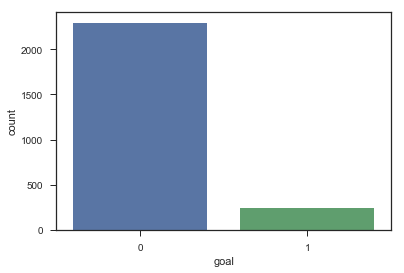

In [64]:
# Remove penalties from the data
np_shots = shots_df[shots_df['type'] != 'Penalty']

# Create a goal column, where 1 = goal and 0 = no goal
np_shots['goal'] = np.where(np_shots['outcome'] == 'Goal', 1, 0)

# Calculate average shot conversion rate
attempts = len(np_shots)
goals = sum(np_shots['goal'])
misses = attempts - goals
conversion_rate = goals / attempts
print("Average conversion rate:", "{0:.2f}%".format(conversion_rate*100))
print("")

# Plot the count of 'goal' and 'no goal' events to show imbalance
sns.set(style="ticks", color_codes=True)
sns.countplot(x="goal", data=np_shots)

Looking at the information above, we can see that under 10% of the shots in the data resulted in a goal. This might seem obvious, but it's an important point as ignoring the imbalance will cause problems with models if we don't do anything to address it, especially when already working with a small dataset to begin with. We will see later how an imbalance in our target variables can lead us to be more confident in our models that we should be. In the interest of time I won't include any further exploration of the data here, but I recommend analysing it in greater detail on your own (see the documentation __[here](https://github.com/statsbomb/open-data/tree/master/doc)__ for more information on the other variables etc).

## Choosing a modelling approach
Supervised machine learning problems can be split into two broad categories - classification and regression. A classification problem is one where you are trying to predict values with two or more discrete categories, for example whether an email is 'spam' or 'not spam'. A regression problem is one where the values you are predicting are continuous, for example the price of a car. In our case we are trying to predict the probability that a shot will result in a goal, so our xG output values can be any number in the range 0-1, which makes this look like a regression problem at first glance. However, I think a better approach is to treat this as a classification problem by training the model to predict 'goal' or 'no goal' for each shot. We can then get our xG values afterwards by looking at the probability estimate the model has assigned to each shot being in either the 'goal' or 'no goal' category.

There are several types of classification models, the most common of which are listed below:

-  Linear classifiers: 
    -  Logistic Regression
    -  Naive Bayes 
-  K-Nearest Neighbours
-  Support Vector Machines
-  Tree-based models: 
    -  Decision Tree
    -  Random Forest
    -  Gradient Boosting Algorithms 
-  Neural Networks

After a brief review of the most popular public xG models (see __[here](https://mackayanalytics.nl/2016/03/28/how-good-are-our-xg-models/)__ for a list), as far as I can tell most models are using either linear or logistic regression, with Martin Eastwood trying out a Support Vector Machines model (__[link](http://pena.lt/y/2015/07/13/expected-goals-svm/)__). I'm personally quite sceptical of the methods typically used to evaluate these models, usually R2 or RMSE. R2 equals explained variation/total variation, so an R2 value of 1 means that the model perfectly explains the variability of data around the mean. You will often see people quoting R2 values of 0.9 or higher, which should immediately set off alarm bells given what we intuitively know about the predictability of goals in football. It's certainly feasible that the on-ball data we have currently can do a great job of explaining most of the variability in the data, but another possibility is that there are some issues with bias or overfitting, as explained __[in this link](https://blog.minitab.com/blog/adventures-in-statistics-2/five-reasons-why-your-r-squared-can-be-too-high)__. RMSE essentially measures how concentrated the data is around a line of best fit, i.e. how close the data points are to the model's predicted values. This can be a useful statistic to evaluate and compare different regression models, but despite the confusing name logistic regression is used for classification problems, not regression! A lower RMSE value does not imply a lower error rate in classification models, as explained __[here](https://www.quora.com/How-is-root-mean-square-error-RMSE-and-classification-related)__. Since logistic regression is by far the most popular technique for making xG models, it's surprising that model performance is commonly evaluated using R2 or RMSE.

So what metrics should we use? The most common metric for assessing classification models is 'accuracy', which is the percentage of correct predictions in the data. However, this isn't really a useful metric here either due to the imbalance between 'goal' and 'no goal' in our data. Imagine a model that predicts 'no goal' 100% of the time. In our case that model would have an accuracy of 90.35%, despite having no predictive power whatsoever! Instead, it makes sense to consider the absolute values of correct and incorrect predictions for each class. These predictions can fall into four separate categories:

-  True Positive (TP): Predicted 'goal' when there was a goal
-  False Positive (FP): Predicted 'goal' when there wasn't a goal
-  True Negative (TN): Predicted 'no goal' when there wasn't a goal
-  False Negative (FN): Predicted 'no goal' when there was a goal

When dealing with an imbalanced dataset, we don't really want to evaluate our model on it's ability to predict true negatives, because there are so many examples in the dataset to begin with. It therefore makes sense to use the following metrics, which don't take true negatives into account:

-  Precision: Of all shots labelled by the model as 'goal', how many were actually goals? Calculated as TP / (TP + FP)
-  Recall: Of all shots that were actually goals, how many did the model identify? Calculated as TP / (TP + FN)
-  F1 Score: The weighted average of precision and recall
-  AUPRC: Area under the precision-recall curve (closer to 1 is better)

Peter McKeever's recent article (__[link](http://petermckeever.com/building-an-expected-goals-model-in-python/)__) on xG models in Python was a step in the right direction, as he touched on these evaluation metrics rather than R2 or RMSE. His logistic regression model achieved the following results:

-  Precision: Positive class = 0.64, negative class = 0.92
-  Recall: Positive class = 0.23, negative class = 0.99
-  F1 Score: Positive class = 0.34, negative class = 0.95
-  AUROC = 0.61 (note that this is different to AUPRC, as a ROC curve plots false positive rate vs true positive rate. True negatives are used to calculate false positive rate, so AUROC can give a misleading picture in cases where there is a class imbalance)

As expected with a class imbalance the model achieves a high precision and recall for the negative class ('no goal'), as there are significantly more examples of 'no goal' situations. However, in an xG model we care much more about the model's ability to predict the positive class (i.e. goals). This model only identified 23% of the actual goals in the dataset correctly (low recall), and just 64% of the shots the model thought were goals were labelled properly. Ideally we want the model to achieve a high precision and recall for the positive class, but there is often a trade-off between the two, so it makes sense to aim for a high recall here as a minimum requirement. It doesn't matter as much if we predict a few 'no goal' situations to be goals, the most important thing is to capture as many actual goals as possible.

In McKeever's defence his aim was to create a simple how-to guide on making xG models in Python, not to produce a model that performs really well. The reason for (perhaps unfairly, sorry!) singling out McKeever's article is that he happened to show his work. The results show how it's much harder to make a good xG model than it might appear initially, especially if you aren't going to do anything to address class imbalance or tune model parameters. These findings should reinforce our scepticism in the performance of xG models since we typically don't know exactly how they are created, although having said that I'd be surprised if I was the first person to have noticed these potential flaws.

The goal of this article series isn't to create a superior xG model to those that are out there already; we are using a very different dataset after all! That said, we might as well try to overcome the limitations of the data as best we can by addressing the class imbalance, choosing a suitable classifier and tuning the parameters. These tasks will be the subject of future articles, but for now we will get started with a basic model.

Since neural networks typically only outperform other algorithms when dealing with very large datasets, I will instead focus on tree-based models throughout this series, which are widely used and considered to be among the best models for classification problems. Unlike logistic regression, tree-based models handle categorical features, correlation and non-linearity well, which is important since most of our model inputs will be categorical variables that can have some correlation to one another.

The simplest example of a tree-based model is a decision tree classifier. We will start with that in this article, before moving on to different classifiers like random forests and gradient boosting algorithms in later parts, which should perform better. Here is an example of a decision tree that you might find in a very simple xG model with two features: 'shot inside box' and 'head or foot':

![Example of a decision tree](http://www.fantasyfutopia.com/wp-content/uploads/2019/01/decision_tree_xg.png)

The most important input feature, 'shot inside box', is at the root of the tree, with branches leading to either internal nodes with more input features (e.g. 'head or foot') or leaf nodes containing the target values (e.g. 'goal'). Obviously this particular example wouldn't produce a very good model, but hopefully it's useful to illustrate how decision trees work! I won't go into further detail on the exact theory here, as there are plenty of guides around if you are interested in learning more.

## Feature engineering

When conducting supervised machine learning, we give the algorithm a dataset that contains one or more variables, or 'features', and ask it to predict specific target values, or 'labels'. However, only using the data in its raw form would be a bit lazy in most cases! Feature engineering is the process of modifying existing variables or creating new ones that will help the algorithm to create a better model. A model can only train itself on what you give it, so starting with good inputs is the best way to improve model performance.

In [65]:
# Feature engineering
# Reset index
np_shots = np_shots.reset_index().drop('level_0', axis=1)

# Create a column to show whether or not the shot was assisted
# This feature won't necessarily have much predictive power, but we may as well find out!
np_shots['assisted'] = np.where(np_shots['key_pass_id'].isna(), 0, 1)

# Create columns for distance and angle
# In this dataset, the pitch is 120 units long and 80 units wide
# We will measure distance and angle from the centre of the goal at (120, 40) to the starting point of the shot
# These features will be easier for the algorithm to interpret than start_location_x etc
np_shots['x_distance'] = 120 - np_shots['start_location_x']
np_shots['y_distance'] = abs(40 - np_shots['start_location_y'])
np_shots['distance'] = np.sqrt((np_shots['x_distance']**2 + np_shots['y_distance']**2))
np_shots['angle'] = np.degrees(np.arctan((np_shots['y_distance'] / np_shots['x_distance'])))

# We would only want to differentiate between left and right foot if we already knew the player's weak foot
# If we don't correct this, 'left foot' might be more predictive than 'right foot' due to the majority of players being right-footed
np_shots['body_part'] = np.where((np_shots['body_part'] == 'Right Foot')
                                 | (np_shots['body_part'] == 'Left Foot'), 'foot',
                                np.where(np_shots['body_part'] == 'Head', 'head', 'other'))

In [72]:
np_shots = np_shots.fillna(0)
np_shots.to_csv('C:/Users/User/Downloads/np_shots.csv')

Based on our knowledge of football, we could guess that additional features such as game state, time, post-shot information (e.g. end location, speed etc), defensive metrics (e.g. number of players between ball and goal), player skill and even weather might be of use in our model. For now I won't include any of those, but feel free to experiment with them in your own models.

In [66]:
# Select model features and labels
feature_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected',
                'assisted', 'distance', 'angle']

features = np_shots[feature_cols]
labels = np_shots['goal']

# Fill missing values
features = features.fillna(0)
labels = labels.fillna(0)

Not all of these features will have a significant amount of predictive power, and it's possible that some will even negatively impact model performance. We may want to remove these features later.

We will be using the decision tree classifier from the sklearn library for our first model. Unlike with logistic regression we don't need to '__[one-hot encode](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)__' the categorical features to ensure that they aren't misinterpreted by the algorithm. In fact, __[one-hot encoding can have a significant negative effect on the performance of tree-based models!](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)__ However, sklearn does expect inputs to be numeric, so we will need to convert the categorical features before we can start modelling. The easiest way to do this is to use 'label encoding', where strings are converted to arbitrary numbers - for example, the 'body_part' feature might change from 'head', 'foot', 'other' to '0', '1', '2'. Tree based models are sophisticated enough to differentiate between categorical and continuous numeric features without the need for any further transformations - a big advantage over logistic regression algorithms.

In [67]:
# Encode categorical features
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected']

cat_features = features[cat_cols]
features = features.drop(cat_cols, axis=1)

# Use label encoding to convert categorical features to numeric
le = preprocessing.LabelEncoder()
cat_features = cat_features.apply(le.fit_transform)

# Merge with numeric features
features = features.merge(cat_features, left_index=True, right_index=True)

# Check it worked
features.dtypes

assisted             int32
distance           float64
angle              float64
play_pattern         int32
under_pressure       int32
body_part            int32
technique            int32
first_time           int32
follows_dribble      int32
redirect             int32
one_on_one           int32
open_goal            int32
deflected            int32
dtype: object

## Training the model
We are almost ready to start training our model, but there is one more crucial step before we get started. Ideally we want to feed our algorithm with as much data as possible to train it. However, it's impossible to evaluate our model properly if we do so. It's likely that the model will overfit to the particular quirks in the dataset and won't generalise well when presented with new data. If we want to be able to use the model in the future, we need to address this issue. There are two options available to us:

-  Split the data into a training set and a test set, e.g. using 80% of the data for training and 20% for testing
-  Use cross-validation techniques like k-fold cross-validation, where the data is split into k subsets. We train the model using k-1 subsets and use the remaining subset to test the model. This process is repeated until all k subsets have been used, at which point the results are averaged

__[This linked article](https://codesachin.wordpress.com/2015/08/30/cross-validation-and-the-bias-variance-tradeoff-for-dummies/)__ does a great job of explaining these techniques further, including the advantages and disadvantages of each method. Since using a train-test split is very common I will show you how to do that here first, and look at swapping to cross-validation in later articles. Note that when using train_test_split we want to set 'shuffle=True' to ensure that the data is ordered randomly. If we don't do this we might encounter a situation where all of the examples of a particular case are contained only in the test set, and vice versa.

In [68]:
# Split data into a training set and a test set
# I have chosen an 80-20 split here
# Setting shuffle=True re-orders the dataset randomly
# Using the same random_state for each model ensures that we can compare different models accurately
# X is our model features, and y is our labels (this is a common naming convention)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, shuffle=True, random_state=42)

# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
# Note that y is already either 0 or 1, so we don't need to do anything to it
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Check that we have the same number of rows and columns in both the training and test set
print(X_train.shape)
print(X_test.shape)

(2032, 13)
(508, 13)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


We are finally ready to train our model!

In [69]:
# Define the algorithm we want to use for our model
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Create predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

## Evaluating the model

Predicted goals (test set): 55
Sum of predicted goal probabilities (aka xG): 61.45
Actual goals (test set): 51

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       457
           1       0.27      0.29      0.28        51

   micro avg       0.85      0.85      0.85       508
   macro avg       0.60      0.60      0.60       508
weighted avg       0.86      0.85      0.85       508



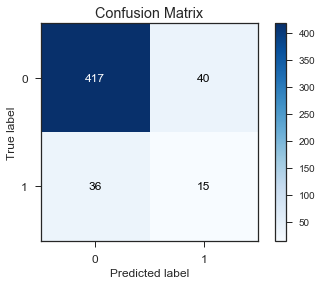

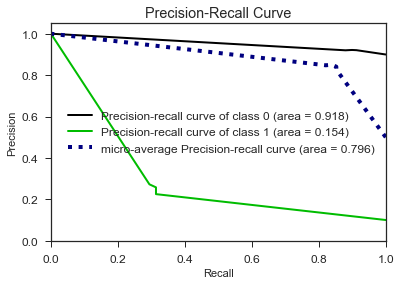

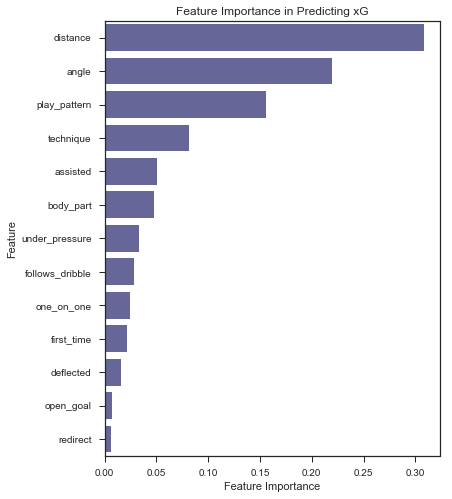

In [70]:
# Print results
print("Predicted goals (test set):", sum(y_pred))
print("Sum of predicted goal probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob[:,1])))
print("Actual goals (test set):", sum(y_test))
print('')
print(metrics.classification_report(y_test, y_pred))

# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

# Get feature importance
importances = pd.DataFrame({'feature':features.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

f, ax = plt.subplots(figsize=(6, 8))
g = sns.barplot(x='importance', y='feature', data=importances,
                color="blue", saturation=.2, label="Total")
g.set(xlabel='Feature Importance', ylabel='Feature', title='Feature Importance in Predicting xG')
plt.show()

Unsurprisingly, our first model isn't very good! If we only checked the number of predicted goals (55) vs actual goals (51) we would think we had a decent model on our hands, but a closer look shows us that we are getting poor precision and recall scores for the positive class due to the imbalance in the dataset. Looking at the confusion matrix, there are significantly more false negatives (36) and false positives (40) than true positives (15), which is far from desirable. Our model isn't identifying the 'goal' situations very well, and it's also predicting 'no goal' incorrectly at a much higher frequency than we would like. The saving grace here is that distance and angle are the most important features in the model (which makes sense), so we could be on the right track if we do something to address the class imbalance. I will look at strategies to do that in the next article, before moving on to different algorithms in the hope of increasing model performance further.

## Conclusion
Thanks very much for reading! If you were able to make it this far you must have enjoyed the article enough to share it on social media, so please do so! The next part should be out soon, but in the meantime if you want to practice on a completely different example see if you can __[predict survival on the Titanic](https://www.kaggle.com/c/titanic#evaluation)__.